# Table of content

* Load the last practical work data (stationary time series)
* Train an AR model
    * [Determine if the process is AR or not using the ACF and PACF plots]
    * [Choose an AR model order and train the model]
        * [Split the data on training and test sets (test period = 1958-01-01, 1960-12-01)]
        * [Build a AR forecasting model using the statsmodel ARIMA class]
        * [Print and interpret the model results summary]
        * [Plot the true observations and the fitted values of the model using the fitted model]
        * [Compute and plot the residual]
* Evaluate your AR model
    * [Forecast the test data using the predict method with a start and end date with multi-step forecasting]
    * [Compute the MAPE score]
    * [Plot the test data and the forecasts]
    * [Implement the expanding window cross validation method with one step and multi step forecasting. Each time plot the predictions against correct values and compute the MAPE score]
        * [One step forecasting: window = 1 (1957-12-01 as a start date for the test set)]
        * [And multi step forecasting: window = 3]
* Repeat the previous steps for MA and ARMA model
* Benchmark result of the 3 models (MAPE, AIC and BIC and fit-time)

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [67]:
import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

pd.set_option('display.max_columns', 20)

In [70]:
Project_Path = Path(".").resolve()
Data_Dir = Project_Path / "data"
Model_Dir = Project_Path / "model"

# Part:1 Load the data and covert the data into stationary

<AxesSubplot:xlabel='Month'>

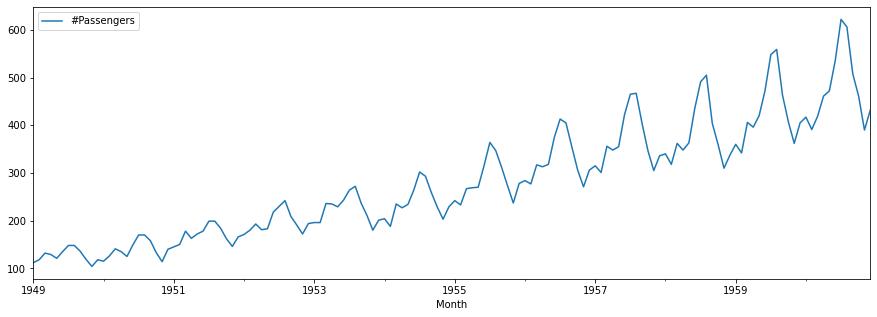

In [71]:
df_master = pd.read_csv(Data_Dir / "AirPassengers.csv", parse_dates=["Month"], index_col="Month")
df_master.plot()

* Coverting the dataset to stationality and ploting


In [72]:
cd ..

c:\Users\npram\Desktop\Github


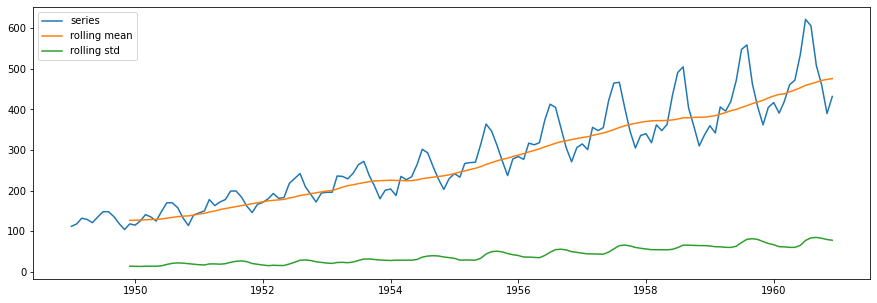

Is the time series stationary ? False
Test statistic value (adf) =  0.82
P value = 0.99
test critical value ('5%') = -2.88


In [73]:
from app.stationality import *

stationary(df_master)

### making the dataset stationality using diff (1st and 2nd etc...)

In [74]:
df_master.diff().head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0


<AxesSubplot:xlabel='Month'>

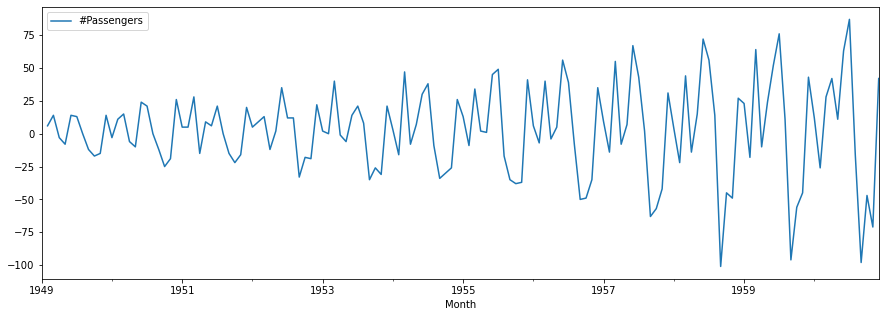

In [75]:
df_master.diff().plot()

* Data log 

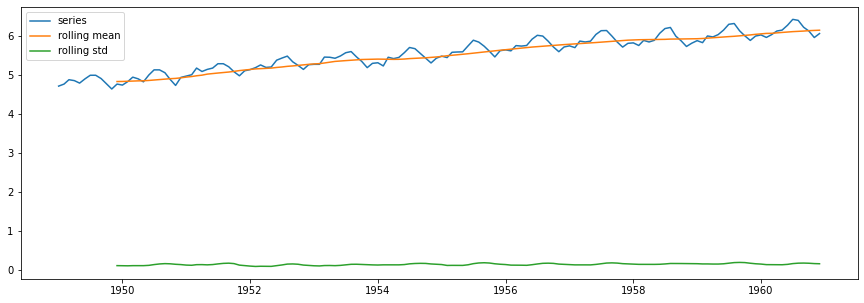

Is the time series stationary ? False
Test statistic value (adf) =  -1.72
P value = 0.42
test critical value ('5%') = -2.88


In [76]:
df_without_exponential_growth = np.log(df_master)
stationary(df_without_exponential_growth)

* Data 1st order differentiation

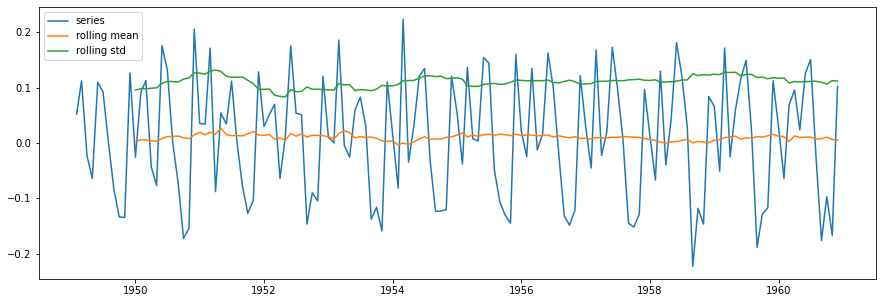

Is the time series stationary ? False
Test statistic value (adf) =  -2.72
P value = 0.07
test critical value ('5%') = -2.88


In [77]:
df_log_1_diff = df_without_exponential_growth.diff().dropna()
stationary(df_log_1_diff)

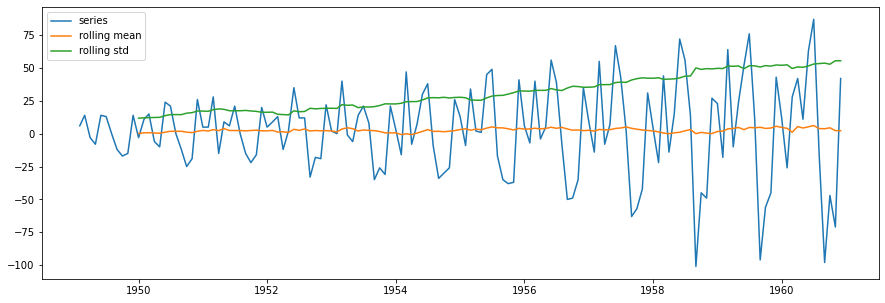

Is the time series stationary ? False
Test statistic value (adf) =  -2.83
P value = 0.05
test critical value ('5%') = -2.88


In [78]:
df_1_diff = df_master.diff().dropna()
stationary(df_1_diff)

* Data second order differentiation

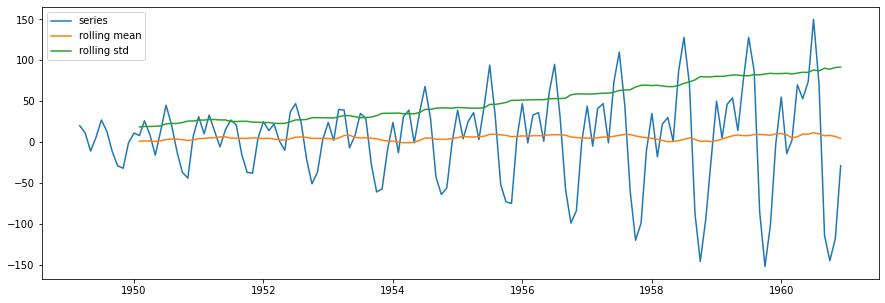

Is the time series stationary ? True
Test statistic value (adf) =  -2.96
P value = 0.04
test critical value ('5%') = -2.88


In [79]:
df_2_diff = df_master.diff(2).dropna()
stationary(df_2_diff)

* Here we can assume that the dataset is stationary becuase we got the pvalue == stationary value we declared. So "df_2_diff" == "stationary_dataset"

# part:2 Training AR model

## 2 a. Determining the AR model from ACF and PACF plot

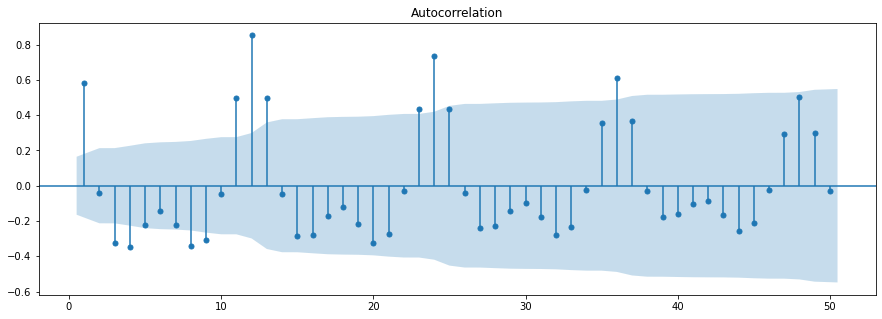

In [80]:
from statsmodels.graphics.tsaplots import plot_acf

_ = plot_acf(df_2_diff, lags=50, zero=False)

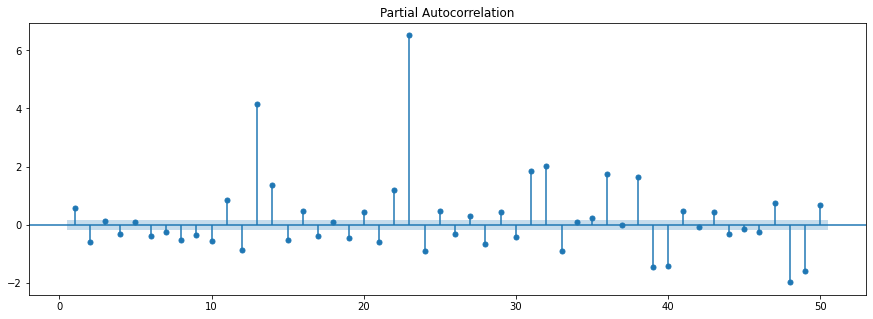

In [81]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(df_2_diff, lags=50, zero=False)

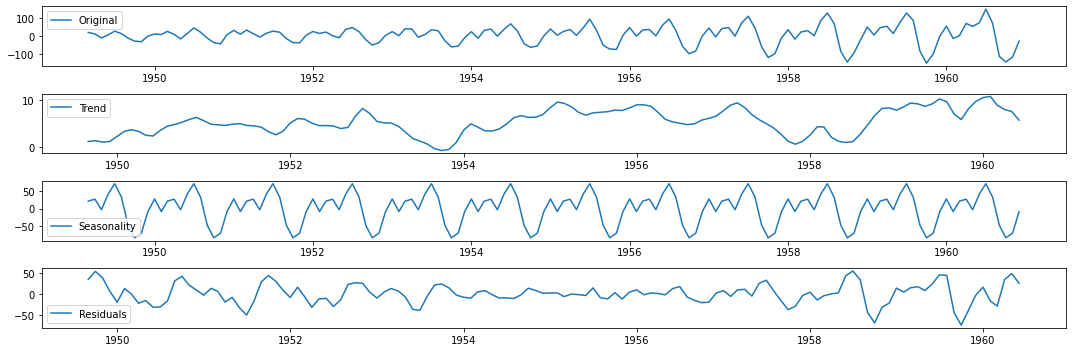

In [82]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(df_2_diff)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.subplot(411)
plt.plot(df_2_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* The ACF graph shows a gradually decreasing trend while the PACF cuts immediately after one lag. Thats, the graph suggest that an AR model would be appropriate for the time series. 

* lag = 14

## 2 b. choose the AR model order and train the model 

### 2 b 1. Split the data on trainingset and testsets

In [83]:
train_data = df_2_diff[:"1957-12-01"]
test_data = df_2_diff["1957-12-01":]

In [84]:
print(train_data.shape, test_data.shape)
train_data[-3:], test_data[:3]

(106, 1) (37, 1)


(            #Passengers
 Month                  
 1957-10-01       -120.0
 1957-11-01        -99.0
 1957-12-01        -11.0,
             #Passengers
 Month                  
 1957-12-01        -11.0
 1958-01-01         35.0
 1958-02-01        -18.0)

### 2 b 2. Build a AR forcasting model

In [85]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(train_data, order=(12,0,0))
model_fit = model.fit()

### 2 b 3. print the model summary

In [86]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  106
Model:                ARIMA(12, 0, 0)   Log Likelihood                -396.704
Date:                Sat, 31 Jul 2021   AIC                            821.408
Time:                        15:29:28   BIC                            858.696
Sample:                    03-01-1949   HQIC                           836.521
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1316      1.148      3.600      0.000       1.882       6.381
ar.L1          0.7102      0.109      6.531      0.000       0.497       0.923
ar.L2         -0.8381      0.113     -7.438      0.000      -1.059      -0.617
ar.L3          0.6773      0.121      5.597      0.000       0.440       0.914
ar.L4         -0.8259      0.136     -6.086      0.000      -1.092      -0.560
ar.L5          0.6836      0.140      4.867      0.000       0.408       0.959
ar.L6         -0.7990      0.151     -5.296      0.000      -1.095      -0.503
ar.L7          0.6107      0.156      3.903      0.000       0.304       0.917
ar.L8         -0.7621      0.157     -4.843      0.000      -1.071      -0.454
ar.L9          0.6027      0.154      3.913      0.000       0.301       0.905
ar.L10        -0.7548      0.144     -5.260      0.000      -1.036      -0.474
ar.L11         0.6281      0.138      4.538      0.000       0.357       0.899
ar.L12         0.1544      0.124      1.247      0.212      -0.088       0.397
sigma2        85.6564     14.424      5.938      0.000      57.386     113.927
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.70
Prob(Q):                              0.90   Prob(JB):                         0.10
Heteroskedasticity (H):               2.07   Skew:                             0.51
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2 b 4. Print and plot the model fitted values

In [87]:
model_fit.fittedvalues

Month
1949-03-01      4.131634
1949-04-01     14.016602
1949-05-01      1.782080
1949-06-01    -14.573401
1949-07-01     16.844495
                 ...    
1957-08-01     31.718857
1957-09-01    -50.470678
1957-10-01   -114.792884
1957-11-01    -91.046411
1957-12-01     -8.682570
Length: 106, dtype: float64

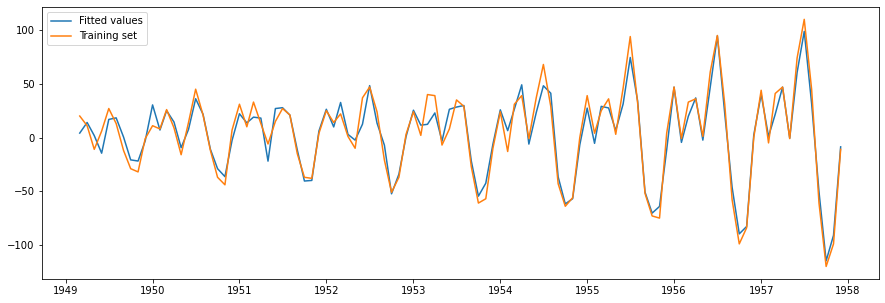

In [88]:
plt.plot(model_fit.fittedvalues, label = "Fitted values")
plt.plot(train_data, label = "Training set")
plt.legend()

### 2 b 5. compute the plot the residuals

In [89]:
model_fit.resid

Month
1949-03-01    15.868366
1949-04-01    -3.016602
1949-05-01   -12.782080
1949-06-01    20.573401
1949-07-01    10.155505
                ...    
1957-08-01    13.281143
1957-09-01   -10.529322
1957-10-01    -5.207116
1957-11-01    -7.953589
1957-12-01    -2.317430
Length: 106, dtype: float64

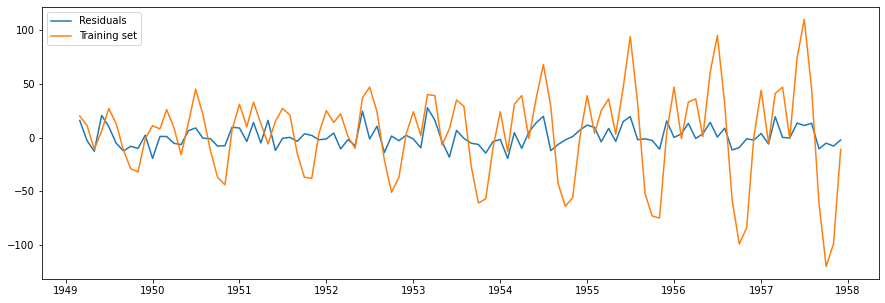

In [90]:
plt.plot(model_fit.resid, label = "Residuals")
plt.plot(train_data, label = "Training set")
plt.legend()

# Part 3: Evaluation of AR model

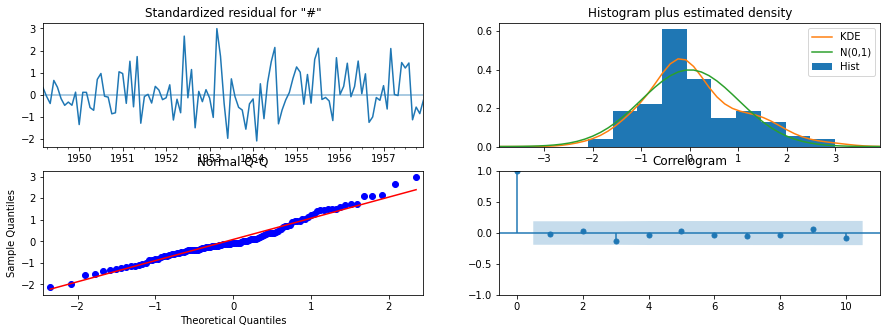

In [91]:
model_fit.plot_diagnostics() 
plt.show()

* Standaridized residual: Appears to be with no seasonal components 
* Estimated density: KDE line closely follows the N(0,1) line, which is standard notation of normal distrubution with zero mean and SD of 1
* Normal Q-Q: shows ordered distrubution of residual(blue) closely follows the linear trend of samples taken
* Correlation: Indicating residual have a low Correlation with lags

### 3 a. Forecast the test data using predict with multi-step forecasting

<AxesSubplot:xlabel='Month'>

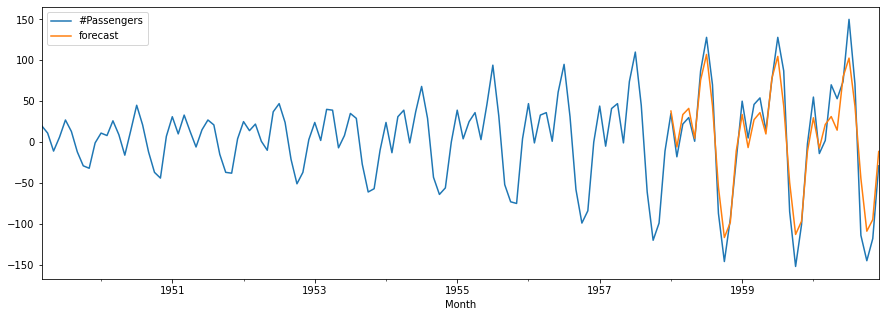

In [92]:
df = pd.DataFrame(df_2_diff)
df['forecast'] = model_fit.predict(start = "1958-01-01", end= "1960-12-01", dynamic= True)  
df[['#Passengers', 'forecast']].plot()

In [93]:
pred = model_fit.predict(start = test_data.index[0], end= test_data.index[-1], dynamic= True)

### 3 b. compute the MAPE score

In [94]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(test_data, pred)
print(MAPE)

0.8163872502737943


In [95]:
# computing RMSE 
mse = ((test_data["#Passengers"] - pred)**2).mean()
rmse = np.sqrt(mse)
print(rmse)

25.562084319200654


### 3 c. Plot the test data and forcasts

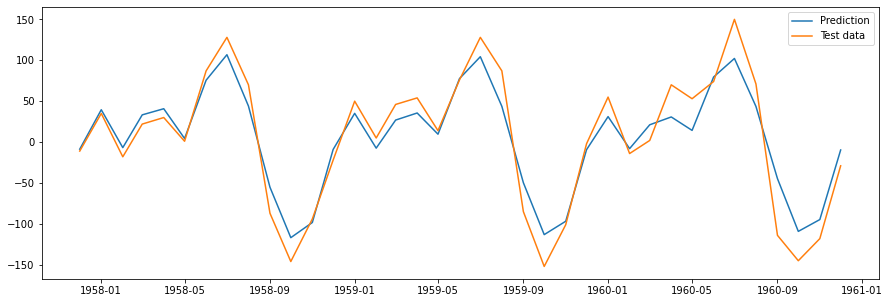

In [96]:
plt.plot(pred, label = "Prediction")
plt.plot(test_data, label = "Test data")
plt.legend()

### 3 d. Implement the expanding windows cross validation method with one step and multi-step

In [97]:
import warnings
warnings.filterwarnings("ignore")

window = 1
nb_forecast = test_data.shape[0]
expanding_window = int(np.ceil(nb_forecast / window))
print(expanding_window)
single_window = ARIMA(test_data, order=(13,0,0))
single_window_fit = single_window.fit()
single_forecast = single_window_fit.predict(start = test_data.index[0], end = test_data.index[window - 1])

37


In [98]:
single_forecast

1957-12-01    4.597776
Freq: MS, dtype: float64

In [99]:
forecast_list = [single_forecast.iloc[0]]

In [100]:
for i in range(expanding_window - 1):
    test  = pd.concat([test_data, test_data[i*window: (i+1)*window]])
    exp_model = ARIMA(test, order=(13,0,0))
    update_fit = exp_model.fit()
    # print(update_fit.summary)
    forecasting = update_fit.predict(start = test_data.index[(i+1)*window], end = test_data.index[(i+2)*window - 1])
    # print(forecasting)
    if window == 1:
        forecast_list.append(forecasting.iloc[0])
        if i%5 == 0: print("step: ", i)
    else:
        print("expand window: ", i)
        print(forecasting)

step:  0
step:  5
step:  10
step:  15
step:  20
step:  25
step:  30
step:  35


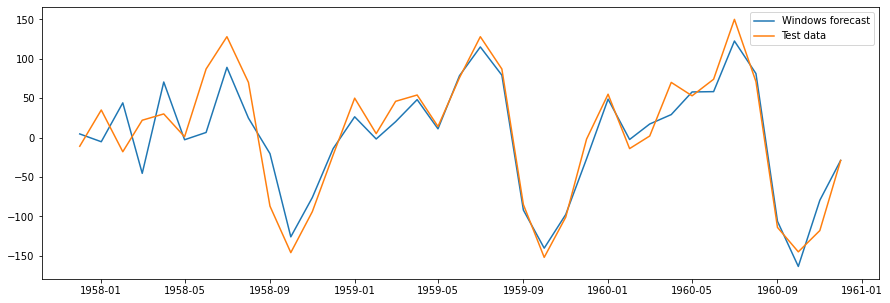

In [101]:
plt.plot(test_data.index, forecast_list, label = "Windows forecast")
plt.plot(test_data, label = "Test data")
plt.legend()

# AR, MA and ARMA model

In [109]:
import time 

def train(train_data, order, model_type, test_data) -> None:
    #model build
    model = ARIMA(train_data, order=order)
    start_time = time.time()
    fit_model = model.fit()
    fit_time = time.time() - start_time
    print(fit_model.summary())

    # Plotting the graph
    plt.plot(fit_model.fittedvalues, label = "Fitted values")
    plt.plot(train_data, label = "Training set")
    plt.legend()
    plt.show()

    plt.plot(fit_model.resid, label = "Residuals")
    plt.plot(train_data, label = "Training set")
    plt.legend()
    plt.show()

    pred = fit_model.predict(start = test_data.index[0], end= test_data.index[-1])
    plt.plot(pred, label = "Prediction")
    plt.plot(test_data, label = "Test data")
    plt.legend()
    plt.show()

    return fit_model, fit_time

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  106
Model:                ARIMA(13, 0, 0)   Log Likelihood                -396.175
Date:                Sat, 31 Jul 2021   AIC                            822.349
Time:                        15:32:35   BIC                            862.301
Sample:                    03-01-1949   HQIC                           838.542
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0645      1.050      3.869      0.000       2.006       6.123
ar.L1          0.7062      0.113      6.232      0.000       0.484       0.928
ar.L2         -0.7393      0.144     -5.127      0.0

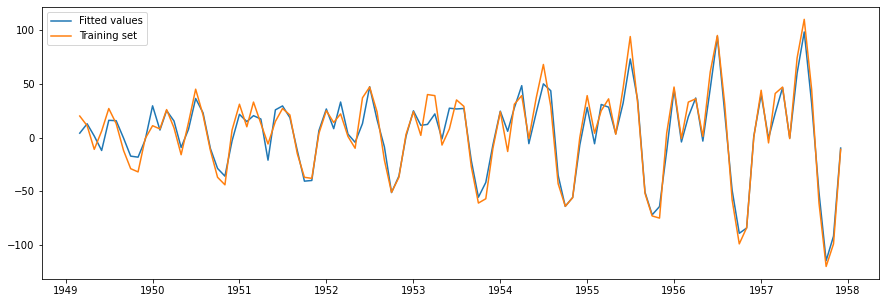

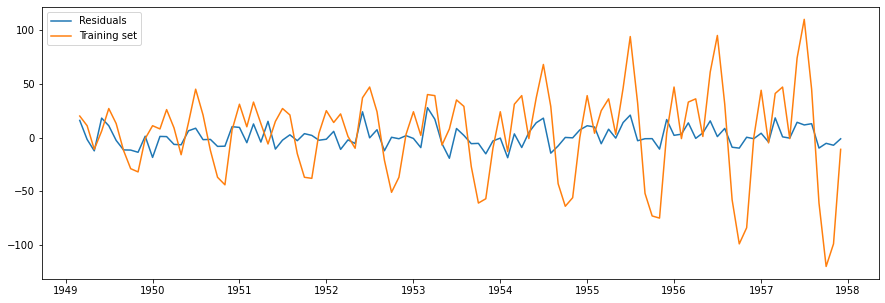

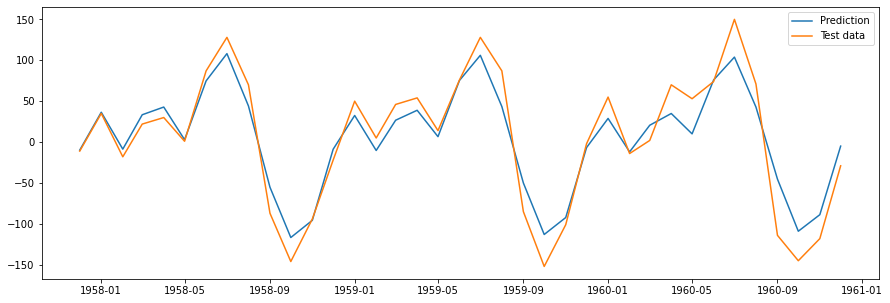

In [110]:
AR_model, AR_fit_time = train(train_data,(13,0,0), "AR", test_data)

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  106
Model:                ARIMA(0, 0, 60)   Log Likelihood                -394.735
Date:                Sat, 31 Jul 2021   AIC                            913.470
Time:                        15:35:12   BIC                           1078.603
Sample:                    03-01-1949   HQIC                           980.399
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2600      2.034      2.586      0.010       1.274       9.246
ma.L1          1.0377   2137.112      0.000      1.000   -4187.625    4189.700
ma.L2         -0.1604   2411.117  -6.65e-05      1.0

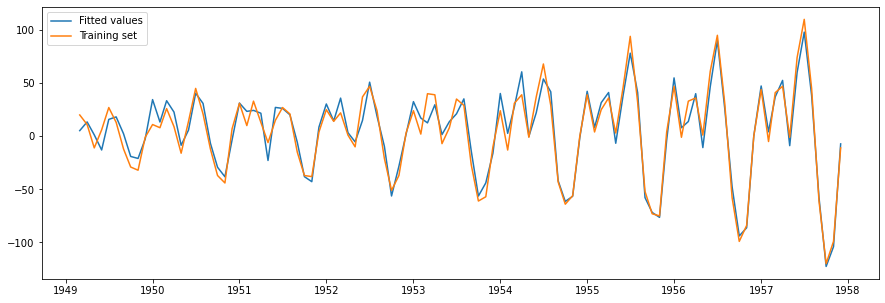

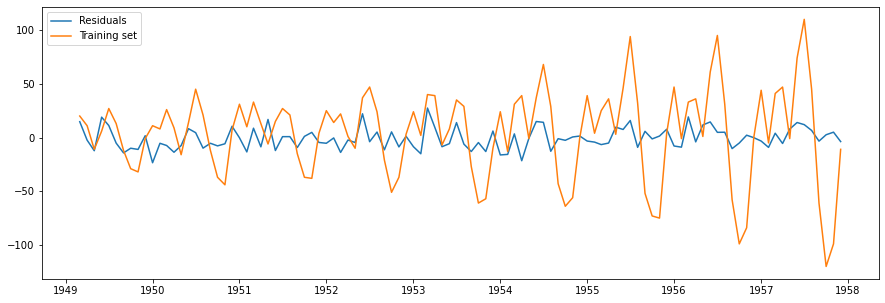

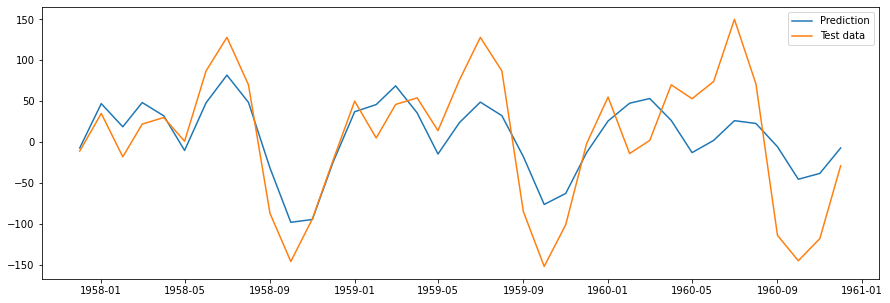

In [116]:
MA_model, MA_fit_time = train(train_data,(0,0,60), "MA", test_data)

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  106
Model:               ARIMA(13, 0, 60)   Log Likelihood                -420.452
Date:                Sat, 31 Jul 2021   AIC                            990.904
Time:                        15:36:16   BIC                           1190.662
Sample:                    03-01-1949   HQIC                          1071.867
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7452      9.502      0.499      0.618     -13.879      23.370
ar.L1          1.5248     51.396      0.030      0.976     -99.209     102.259
ar.L2         -1.2888    105.214     -0.012      0.9

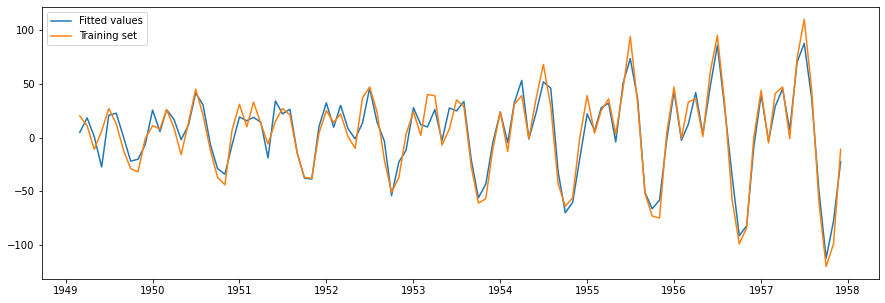

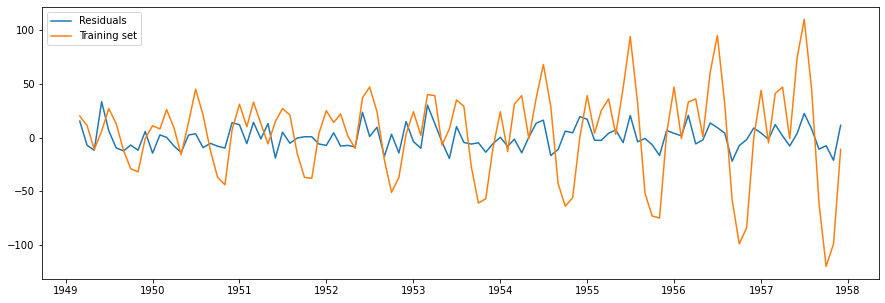

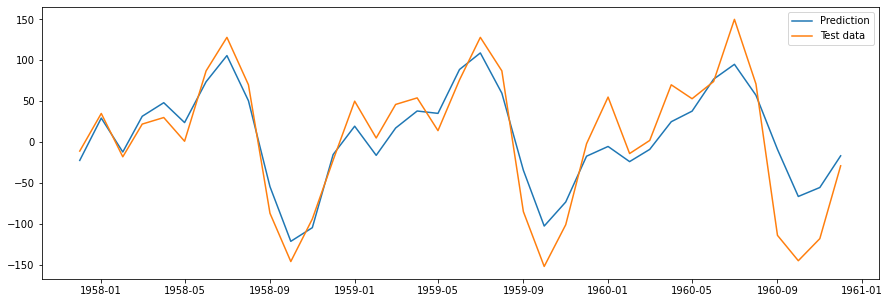

In [117]:
ARMA_model, ARMA_fit_time = train(train_data, (13,0,60), "ARMA", test_data)

# Benchmark result of the 3 models
    

In [125]:
def scores(model, test_data, model_type, fit_time):
    pred = model.predict(start = test_data.index[0] , end = test_data.index[-1], dynamic=True)
    metrics = {}
    metrics[model_type] = {}
    metrics[model_type]["Name"] = model_type
    metrics[model_type]["MAPE"] =  mean_absolute_percentage_error(test_data, pred)
    metrics[model_type]["AIC"] =  model.aic
    metrics[model_type]["BIC"] =  model.bic
    metrics[model_type]["fit_time"] =  fit_time
    return metrics

In [126]:
ar = scores(AR_model, test_data,"AR", AR_fit_time)
ma = scores(MA_model, test_data,"MA", AR_fit_time)
arma = scores(ARMA_model, test_data,"ARMA", AR_fit_time)
print(ar)
print(ma)
print(arma)

{'AR': {'Name': 'AR', 'MAPE': 0.7309869242484998, 'AIC': 822.3492282076661, 'BIC': 862.3008146193471, 'fit_time': 1.013007402420044}}
{'MA': {'Name': 'MA', 'MAPE': 2.0322750337421374, 'AIC': 913.469693421643, 'BIC': 1078.6029172565911, 'fit_time': 1.013007402420044}}
{'ARMA': {'Name': 'ARMA', 'MAPE': 1.7725038277412812, 'AIC': 990.9044632210597, 'BIC': 1190.6623952794648, 'fit_time': 1.013007402420044}}


In [128]:
results = {**ar, **ma, **arma}
models = []
scores = []

for model, score in results.items():
    models.append(model)
    scores.append(score)

dataframe = pd.DataFrame(scores)
dataframe.head()

,Name,MAPE,AIC,BIC,fit_time
0,AR,0.730987,822.349228,862.300815,1.013007
1,MA,2.032275,913.469693,1078.602917,1.013007
2,ARMA,1.772504,990.904463,1190.662395,1.013007


In [130]:
import plotly.express as px
fig = px.bar(dataframe, x='Name', y='MAPE', title="MAPE scores")
fig.show()

In [131]:
fig = px.bar(dataframe, x='Name', y='AIC', title="AIC scores")
fig.show()

In [132]:
fig = px.bar(dataframe, x='Name', y='BIC', title="BIC scores")
fig.show()

In [133]:
fig = px.bar(dataframe, x='Name', y='fit_time', title="Model fit time")
fig.show()